In [1]:
# Import dependecies
import Pkg
Pkg.activate("psyc261")
Pkg.add("Plots")
Pkg.add("ProgressBars")
Pkg.add("Gen")
Pkg.add(["CSV", "DataFrames"])
Pkg.add("Distributions")
Pkg.add("HypothesisTests")
Pkg.add("GLM")
Pkg.add("Glob")
using Gen
using Glob
using ProgressBars
using Plots
using CSV
using DataFrames
using Distributions
using Statistics
using HypothesisTests
using Random
using GLM
include("utils/draw.jl")
;

  Activating project at `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261`
   Resolving package versions...
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Project.toml`
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Project.toml`
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Project.toml`
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Project.toml`
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `

#### **Musical Scale Initialization**
The majority of this code is altered from Nguyen et al. (2025) by now encoding a note by its value and its position in a measure. My contributions in this code base are refactoring to include latent position, the design of the MLP to infer duration from latent position.

In [2]:
# A note is encoded by its value and its metrical position, P.
struct Note
    value::Float64
    position::Int64
end

# A scale is encoded by its key name and its internal notes.
struct MusicalScale
    name::Symbol
    notes::Vector{Note}
end

# For the time being, assume that we have exaclty 8 notes per measure.
MEASURE_LENGTH = 8

# A measure is encoded by the notes inside of it and its duration
latent_position(note::Note) = mod(note.position - 1, MEASURE_LENGTH) + 1
latent_interval(note1::Note, note2::Note) = note2.value - note1.value
;

In [3]:
function create_scale(name::Symbol, root_note::Int, root_duration::Int, intervals::Vector{Int})
    notes = Note[]
    pos = 1
    for interval in intervals
        push!(notes, Note(root_note + interval, pos))
        pos = mod(pos + root_duration - 1, MEASURE_LENGTH) + 1
    end
    return MusicalScale(name, notes)
end

function create_major_scale(root_note::Int, root_duration::Int=8)
    MAJOR_INTERVALS = [0, 2, 4, 5, 7, 9, 11, 12]
    return create_scale(:major, root_note, root_duration, MAJOR_INTERVALS)
end

note_values(scale::MusicalScale) = [n.value for n in scale.notes]
note_positions(scale::MusicalScale) = [n.position for n in scale.notes]

function findnearest(value::Note, array::Vector{Note}, exclude=nothing)
    filtered = isnothing(exclude) ? array : filter(n -> n != exclude, array)
    idx = argmin(abs.(value.value .- [n.value for n in filtered]))
    return filtered[idx]
end
;

In [4]:
# I create some major scales for the model to draw from later on
C_NOTE = 60

C = create_major_scale(C_NOTE)
G = create_major_scale(55)  
D = create_major_scale(62)  
A = create_major_scale(57)  
E = create_major_scale(64)  
B = create_major_scale(59)  
F♯ = create_major_scale(66)
G♭ = create_major_scale(66)
D♭ = create_major_scale(61)
A♭ = create_major_scale(56)
E♭ = create_major_scale(63)
B♭ = create_major_scale(58)
F = create_major_scale(65)

major_scales = [C, G, D, A, E, B, F♯, G♭, D♭, A♭, E♭, B♭, F]
;

In [5]:
# Quick utility function to calculate duration
# signed, wrapped duration in beats, 0..(MEASURE_LENGTH-1)
function duration(note1::Note, note2::Note)
    return mod(note2.position - note1.position, MEASURE_LENGTH)
end
;

#### **Calculating musical forces**
I also need to create some functions to calculate the musical forces. All of these functions will take the key and current pitch (as an integer) as inputs and output to what extent each force should be applied given the position of the note in the scale (the degree), the position of the note in the measure, and the scale itself. These have to be changed to account for the new duration parameter, which breaks note subtraction.

In [6]:
function calculate_gravity(note::Note, key::MusicalScale)
    gravity_force = 0.0

    # Extract scale pitch values
    scale_values = [n.value for n in key.notes]

    # Find scale degree by pitch (not by struct equality)
    degree = findfirst(v -> v == note.value, scale_values)

    if degree !== nothing
        gravity_force = -0.05 * degree
    else
        nearest_stable_pitch = findnearest(note, key.notes)
        gravity_force = -0.05 * abs(note.value - nearest_stable_pitch.value)
    end

    return gravity_force
end
;

In [7]:
function magnetism_potential(note::Note, key::MusicalScale)
    nearest = findnearest(note, key.notes)
    second_nearest = findnearest(note, key.notes, nearest)

    dto   = abs(note.value - nearest.value)
    dfrom = abs(note.value - second_nearest.value)

    magnetism_force = (1 / (dto^2 + 1)) - (1 / (dfrom^2 + 1))

    return magnetism_force
end
;

function calculate_magnetism(note::Note, key::MusicalScale; ϵ = 1e-3)
    U0 = magnetism_potential(note, key)

    note_up   = Note(note.value + ϵ, note.position)
    note_down = Note(note.value - ϵ, note.position)

    U_up   = magnetism_potential(note_up, key)
    U_down = magnetism_potential(note_down, key)

    # numerical derivative
    return -(U_up - U_down) / (2ϵ)
end

calculate_magnetism (generic function with 1 method)

In [8]:
function calculate_inertia(prev_note::Note, curr_note::Note, key::MusicalScale)
    Δ = curr_note.value - prev_note.value

    scale_values = [n.value for n in key.notes]
    degree = findfirst(v -> v == curr_note.value, scale_values)

    base = 0.25
    deg_factor = isnothing(degree) ? 1.0 : 0.6 + 0.05 * degree
    strength = min(0.45, base * deg_factor)

    if Δ > 0
        return +strength
    elseif Δ < 0
        return -strength
    else
        return 0.0
    end
end
;

Next, we create the rhythmic kernel for the scaling coefficients.

In [9]:
# Use 0-based positions internally
pos0(note::Note) = note.position - 1  # 0..7
Δt0(note1::Note, note2::Note) = mod(note2.position - note1.position, MEASURE_LENGTH)
;

In [10]:
const DUR_TRANS = DataFrame(CSV.File("./data/temperley_training/bigram_data.csv"))
function normalize(v)
    s = sum(v)
    s == 0 ? fill(1/length(v), length(v)) : v ./ s
end

# Use 0-based positions internally
pos0(note::Note) = note.position - 1  # 0..7
Δt0(note1::Note, note2::Note) = mod(note2.position - note1.position, MEASURE_LENGTH)

const DUR_MAT = Array{Float64}(DUR_TRANS)
const DUR_COLS = [normalize(DUR_MAT[:, j] .+ 1e-5) for j in 1:size(DUR_MAT, 2)]

function get_empirical_probabilities(prev_pos0::Int; ε=1e-6)
    j = clamp(prev_pos0 + 1, 1, size(DUR_MAT, 2))
    probs = DUR_MAT[:, j]

    # Dirichlet-style smoothing
    probs = probs .+ ε
    return probs ./ sum(probs)
end
;

In [38]:
@gen function melody_kernel(k::Int, state::Tuple{Note,Note}, key::MusicalScale)
    # -----------------------------
    # Hyperparameters
    # -----------------------------
    w_g, w_m, w_i = 0.3, 0.6, 0.2
    α = 0.5

    σ_step_base = 0.5
    σ_pitch_obs = 0.7
    γ = 0.25

    prev_note, curr_note = state

    # -----------------------------
    # 1) Empirical rhythm model
    # -----------------------------
    prev_pos0 = curr_note.position - 1
    probs = get_empirical_probabilities(prev_pos0)
    Δt ~ categorical(probs)

    # -----------------------------
    # 2) Deterministic melodic forces
    # -----------------------------
    gravity   = calculate_gravity(curr_note, key)
    magnetism = calculate_magnetism(curr_note, key)
    inertia   = calculate_inertia(prev_note, curr_note, key)

    base_force = w_g * gravity + w_m * magnetism + w_i * inertia

    rhythm_scale = Δt^γ

    μ_step = α * rhythm_scale * base_force
    σ_step = σ_step_base * sqrt(Δt)

    # -----------------------------
    # 3) Pitch evolution
    # -----------------------------
    step ~ normal(μ_step, σ_step)

    next_pitch = curr_note.value + step
    next_pos   = mod(curr_note.position - 1 + Δt, MEASURE_LENGTH) + 1

    # Observation anchor (soft)
    obs_pitch ~ normal(next_pitch, σ_pitch_obs)

    next_note = Note(next_pitch, next_pos)
    return (curr_note, next_note)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Tuple{Note, Note}, MusicalScale], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##melody_kernel#300", Bool[0, 0, 0], false)

Let's alter the example melody generation.

In [39]:
chain = Gen.Unfold(melody_kernel)

@gen function melody(
    K::Int,
    key=nothing,
    init_notes=nothing
)
    σ_init = 0.25

    key = isnothing(key) ?
        @trace(draw(major_scales, fill(1 / length(major_scales), length(major_scales))), :key) :
        key

    # Second-order init state
    if isnothing(init_notes)
        start_pitch ~ normal(key.notes[8].value, σ_init)
        x₁ = Note(start_pitch, 1)

        init_step ~ normal(0, 1)
        x₂ = Note(x₁.value + init_step, 2)

        init_state = (x₁, x₂)
    else
        init_state = init_notes
    end

    states ~ chain(K - 2, init_state, key)

    notes = Note[init_state[1], init_state[2]]
    for st in states
        push!(notes, st[2])
    end

    return notes
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Any, Any], true, Union{Nothing, Some{Any}}[nothing, Some(nothing), Some(nothing)], var"##melody#301", Bool[0, 0, 0], false)

In [40]:
trace = Gen.simulate(melody, (10,)) 
get_retval(trace)

10-element Vector{Note}:
 Note(72.93437770330566, 1)
 Note(72.43434262698472, 2)
 Note(72.8218853308924, 2)
 Note(71.03455250483363, 1)
 Note(70.15526579054551, 6)
 Note(70.60755349554161, 1)
 Note(70.4559849791257, 8)
 Note(70.2740610097872, 5)
 Note(70.63095072200298, 6)
 Note(71.5897592529678, 2)

In [41]:
get_choices(trace)

│
├── :key : MusicalScale(:major, Note[Note(61.0, 1), Note(63.0, 1), Note(65.0, 1), Note(66.0, 1), Note(68.0, 1), Note(70.0, 1), Note(72.0, 1), Note(73.0, 1)])
│
├── :start_pitch : 72.93437770330566
│
├── :init_step : -0.5000350763209385
│
└── :states
    │
    ├── 1
    │   │
    │   ├── :step : 0.3875427039076777
    │   │
    │   ├── :obs_pitch : 71.66132827940237
    │   │
    │   └── :Δt : 8
    │
    ├── 2
    │   │
    │   ├── :step : -1.7873328260587669
    │   │
    │   ├── :obs_pitch : 70.46551355882099
    │   │
    │   └── :Δt : 7
    │
    ├── 3
    │   │
    │   ├── :step : -0.8792867142881188
    │   │
    │   ├── :obs_pitch : 68.94233240279459
    │   │
    │   └── :Δt : 5
    │
    ├── 4
    │   │
    │   ├── :step : 0.4522877049960901
    │   │
    │   ├── :obs_pitch : 70.10110820936143
    │   │
    │   └── :Δt : 3
    │
    ├── 5
    │   │
    │   ├── :step : -0.15156851641590063
    │   │
    │   ├── :obs_pitch : 70.58820282147296
    │   │
    │   └── :Δt : 7
    

In [42]:
# MIDI-Style piano roll
notes = get_retval(trace)
scale = trace[:key]                 
tonic_value = scale.notes[1].value

const PITCH_CLASSES = ["C", "C♯", "D", "E♭", "E", "F",
                       "F♯", "G", "A♭", "A", "B♭", "B"]

pitch_name(v) = PITCH_CLASSES[mod(Int(round(v)), 12) + 1]
function durations_from_positions(notes; L=MEASURE_LENGTH)
    N = length(notes)
    durs = Vector{Int}(undef, N)
    
    for i in 1:N-1
        Δ = duration(notes[i], notes[i + 1])
        durs[i] = Δ > 0 ? Δ : Δ + L
    end
    durs[end] = L - notes[end].position + 1
    return durs
end

durations = durations_from_positions(notes)
start_times = cumsum([0; durations[1:end-1]])

10-element Vector{Int64}:
  0
  1
  9
 16
 21
 24
 31
 36
 37
 41

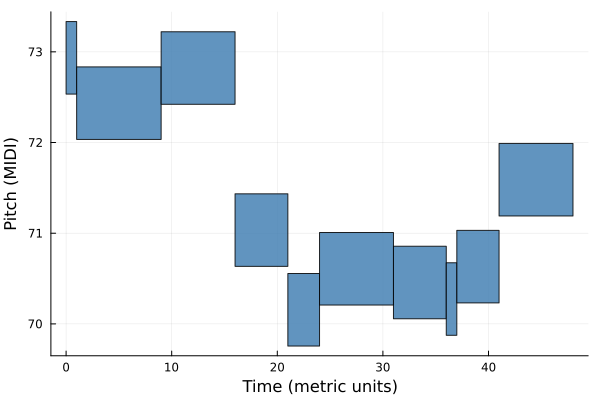

In [43]:
key_label = "Key: $(pitch_name(tonic_value)) Major"
plt = plot(
    xlabel = "Time (metric units)",
    ylabel = "Pitch (MIDI)",
    grid = true,
    legend = :topright,
    label = key_label
)

for (t, d, n) in zip(start_times, durations, notes)
    v = n.value
    plot!(
        [t, t+d, t+d, t],
        [v-0.4, v-0.4, v+0.4, v+0.4],
        seriestype = :shape,
        color = :steelblue,
        alpha = 0.85,
        label = false
    )
end

display(plt)

#### **Particle Filtering**
(CHANGE THIS)
Next, I will implement a basic particle filter to better solve this inference problem. The structures of the following functions is intentionally tailored to the existing dataset that I have. A study by Morgan et al. (2019) asked participants to listen to a "melodic stem", a set of 6-9 notes that make the beginning of a melody, and sing what they think the last note should be. The purpose of my model is to output a similar end note to the human participants. First, I will create `make_observations` which creates a data frame from a vector of notes **and rhythms** and the key with gravity, magnetism, and inertia values at each time step. This data frame will be used to load observations into the particle filter. 

In [44]:
function make_observations(
    notes::Vector{Float64},
    positions::Vector{Int64},
    key::MusicalScale
)
    @assert length(notes) == length(positions)

    observed_notes = [Note(n, p) for (n, p) in zip(notes, positions)]

    gravity   = calculate_gravity.(observed_notes, Ref(key))
    magnetism = calculate_magnetism.(observed_notes, Ref(key))

    # Second-order inertia
    inertia = Float64[]
    push!(inertia, 0.0)  # no inertia for first note

    for i in 2:length(observed_notes)
        prev_note = observed_notes[i-1]
        curr_note = observed_notes[i]
        push!(
            inertia,
            calculate_inertia(prev_note, curr_note, key)
        )
    end

    return DataFrame(
        obs_notes = observed_notes,
        position  = positions,
        gravity   = gravity,
        magnetism = magnetism,
        inertia   = inertia
    )
end

make_observations (generic function with 1 method)

Let's alter the example melody sequence to incorporate a rhythmic component.

In [45]:
key = G

# Observed notes and their rhythmic positions. Let's say we have a 4/4 measure.
# Actual last note is 67.
observed_note_values = [62.0, 59.0, 55.0, 62.0, 64.0, 60.0, 66.0, 62.0, 67.0]

# Let's see what happens when we accelerate the melody.
observed_positions = [1, 3, 5, 7, 5, 6, 7, 8, 1]

obs_notes = make_observations(observed_note_values[1:end-1], observed_positions[1:end-1], key)
;

In [46]:
obs_notes

Row,obs_notes,position,gravity,magnetism,inertia
,Note,Int64,Float64,Float64,Float64
1,"Note(62.0, 1)",1,-0.25,-0.0,0.0
2,"Note(59.0, 3)",3,-0.15,0.5,-0.1875
3,"Note(55.0, 5)",5,-0.05,0.16,-0.1625
4,"Note(62.0, 7)",7,-0.25,-0.0,0.2125
5,"Note(64.0, 5)",5,-0.3,5.55112e-13,0.225
6,"Note(60.0, 6)",6,-0.2,-0.5,-0.2
7,"Note(66.0, 7)",7,-0.35,0.5,0.2375
8,"Note(62.0, 8)",8,-0.25,-0.0,-0.2125


In [47]:
function particle_filter(num_particles::Int, num_samples::Int,
                         key::MusicalScale, obs_df::DataFrame)

    T = nrow(obs_df)
    @assert T ≥ 2 "Need at least two observed notes"

    obs_notes  = Vector{Note}(obs_df.obs_notes)
    init_state = (obs_notes[1], obs_notes[2])

    init_obs = Gen.choicemap(:key => key)

    # Start with K = 2 (only the initial second-order state exists)
    init_args = (2, nothing, init_state)
    state = Gen.initialize_particle_filter(melody, init_args, init_obs, num_particles)

    prev_K = 2
    for t in 3:T
        Gen.maybe_resample!(state, ess_threshold = num_particles ÷ 4)

        K = t
        k = t - 2  # index into :states

        obs = Gen.choicemap()

        Δt = mod(obs_df[t, :position] - obs_df[t-1, :position], MEASURE_LENGTH)
        Δt = (Δt == 0) ? MEASURE_LENGTH : Δt

        obs[:states => k => :Δt] = Δt
        obs[:states => k => :obs_pitch] = obs_notes[t].value
        
        new_args = (K, nothing, init_state)

        # Only K changed; other args are unchanged.
        Gen.particle_filter_step!(
            state,
            new_args,
            (UnknownChange(), NoChange(), NoChange()),
            obs
        )

        prev_K = K
    end

    # Note that the final step is always to the downbeat!
    K_forecast = T + 1
    k_forecast = K_forecast - 2          # = T - 1 (index into :states)

    last_pos = obs_df[T, :position]
    Δt_f = mod(1 - last_pos, MEASURE_LENGTH)
    Δt_f = (Δt_f == 0) ? MEASURE_LENGTH : Δt_f

    obs_f = Gen.choicemap()
    obs_f[:states => k_forecast => :Δt] = Δt_f

    Gen.particle_filter_step!(
        state,
        (K_forecast, nothing, init_state),
        (UnknownChange(), NoChange(), NoChange()),
        obs_f
    )

    return Gen.sample_unweighted_traces(state, num_samples)
end

particle_filter (generic function with 1 method)

In [48]:
Random.seed!(704)
pf_traces = particle_filter(2000, 200, key, obs_notes)

200-element Vector{Gen.DynamicDSLTrace}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Any, Any], true, Union{Nothing, Some{Any}}[nothing, Some(nothing), Some(nothing)], var"##melody#301", Bool[0, 0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:key => Gen.ChoiceOrCallRecord{MusicalScale}(MusicalScale(:major, Note[Note(55.0, 1), Note(57.0, 1), Note(59.0, 1), Note(60.0, 1), Note(62.0, 1), Note(64.0, 1), Note(66.0, 1), Note(67.0, 1)]), -2.5649493574615367, NaN, true), :states => Gen.ChoiceOrCallRecord{Gen.VectorTrace{Gen.UnfoldType, Any, Gen.DynamicDSLTrace}}(Gen.VectorTrace{Gen.UnfoldType, Any, Gen.DynamicDSLTrace}(Unfold{Any, Gen.DynamicDSLTrace}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Tuple{Note, Note}, MusicalScale], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##melody_kernel#300", Bool[0, 0, 0], false)), Gen.Dynam

In [49]:
# The value to beat is 69.225, where the real value is 67!
last_notes = Note[]

for trace in pf_traces
    states = trace[:states]          # Vector{Tuple{Note, Note}}
    (_, last_note) = states[end]     # curr_note at final step
    push!(last_notes, last_note)
end

pred_note_vals = [n.value for n in last_notes]
mu = mean(pred_note_vals)

62.925556908402484

In [50]:
function visualize_samples(samples::Vector{Gen.DynamicDSLTrace},
                           obs_notes::Vector{Note})

    plot()
    pred_note_vals = Float64[]

    for trace in samples
        states = trace[:states]  # Vector{Tuple{Note, Note}}

        # Reconstruct melody: take curr_note from each state
        notes = [obs_notes[1] ; obs_notes[2] ; [st[2] for st in states]]

        seq_vals = [n.value for n in notes]
        push!(pred_note_vals, seq_vals[end])

        plot!(
            seq_vals,
            linewidth = 2,
            alpha = 0.20,
            color = :firebrick,
            legend = false
        )
    end

    # Observed melody
    obs_vals = [n.value for n in obs_notes]
    plot!(
        obs_vals,
        linewidth = 4,
        linestyle = :solid,
        color = :red,
        label = "Observed Sequence"
    )

    true_final = obs_vals[end]
    mu = mean(pred_note_vals)

    hline!(
        [true_final],
        color = :black,
        linewidth = 1,
        linestyle = :solid,
        label = "True Final Note"
    )

    hline!(
        [mu],
        color = :black,
        linewidth = 1,
        linestyle = :dash,
        label = "Mean Predicted Final Note"
    )

    xlabel!("Time Step")
    ylabel!("Pitch (MIDI)")
    title!("Particle Filter Samples")
    display(plot!())
end
;

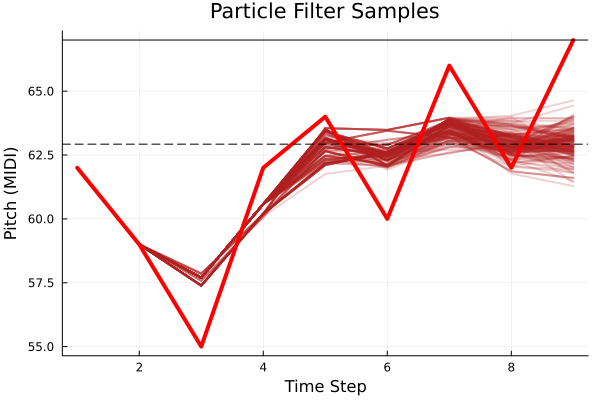

In [51]:
init_note = Note(62.0, 1)

# Observed notes and their rhythmic positions. Let's say we have a 4/4 measure.
observed_note_values = [62.0, 59.0, 55.0, 62.0, 64.0, 60.0, 66.0, 62.0, 67.0]
observed_positions = [1, 3, 5, 7, 5, 6, 7, 8, 1]
observed_notes = [Note(n, p) for (n, p) in zip(observed_note_values, observed_positions)]

visualize_samples(pf_traces, observed_notes)

In [52]:
# Altering back to uniform metrical duration
unif_observed_positions = [1, 3, 5, 7, 1, 3, 5, 7, 1]

unif_obs_notes = make_observations(observed_note_values[1:end-1], unif_observed_positions[1:end-1], key)

Row,obs_notes,position,gravity,magnetism,inertia
,Note,Int64,Float64,Float64,Float64
1,"Note(62.0, 1)",1,-0.25,-0.0,0.0
2,"Note(59.0, 3)",3,-0.15,0.5,-0.1875
3,"Note(55.0, 5)",5,-0.05,0.16,-0.1625
4,"Note(62.0, 7)",7,-0.25,-0.0,0.2125
5,"Note(64.0, 1)",1,-0.3,5.55112e-13,0.225
6,"Note(60.0, 3)",3,-0.2,-0.5,-0.2
7,"Note(66.0, 5)",5,-0.35,0.5,0.2375
8,"Note(62.0, 7)",7,-0.25,-0.0,-0.2125


In [53]:
Random.seed!(704)
unif_pf_traces = particle_filter(2000, 200, key, unif_obs_notes)

200-element Vector{Gen.DynamicDSLTrace}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Any, Any], true, Union{Nothing, Some{Any}}[nothing, Some(nothing), Some(nothing)], var"##melody#301", Bool[0, 0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:key => Gen.ChoiceOrCallRecord{MusicalScale}(MusicalScale(:major, Note[Note(55.0, 1), Note(57.0, 1), Note(59.0, 1), Note(60.0, 1), Note(62.0, 1), Note(64.0, 1), Note(66.0, 1), Note(67.0, 1)]), -2.5649493574615367, NaN, true), :states => Gen.ChoiceOrCallRecord{Gen.VectorTrace{Gen.UnfoldType, Any, Gen.DynamicDSLTrace}}(Gen.VectorTrace{Gen.UnfoldType, Any, Gen.DynamicDSLTrace}(Unfold{Any, Gen.DynamicDSLTrace}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Tuple{Note, Note}, MusicalScale], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##melody_kernel#300", Bool[0, 0, 0], false)), Gen.Dynam

In [54]:
# The value to beat is 69.225, where the real value is 67!
unif_last_notes = Note[]

for trace in unif_pf_traces
    states = trace[:states]          # Vector{Tuple{Note, Note}}
    (_, last_note) = states[end]     # curr_note at final step
    push!(unif_last_notes, last_note)
end

pred_note_vals = [n.value for n in unif_last_notes]
mu = mean(pred_note_vals)

62.74934070899367

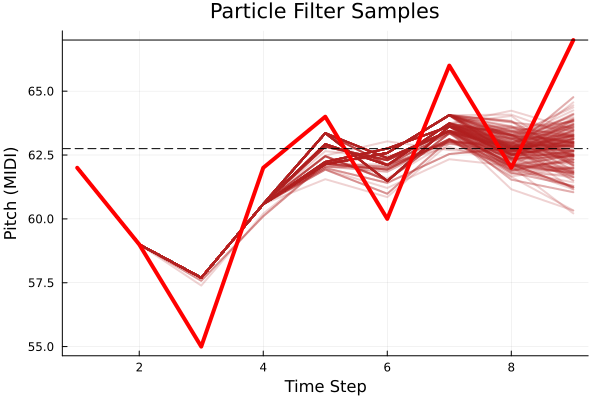

In [55]:
visualize_samples(unif_pf_traces, observed_notes)

### **Experiment: Model vs Human Performance in Melodic and Rhythmic Expectation**

I have altered the method used to read CSV files from Nguyen et al. because I could not understand what the tops of each of the files meant. The files are encoding the note name and the rhythm, where the file name "X - KEY" denotes the melodic stem in the Morgan et al. (2018) dataset and the key of the excerpt.

In [56]:
const KEY_MAP = Dict(
    "C"  => C,
    "G"  => G,
    "D"  => D,
    "A"  => A,
    "E"  => E,
    "B"  => B,
    "F#" => F♯,
    "Gb" => G♭,
    "Db" => D♭,
    "Ab" => A♭,
    "Eb" => E♭,
    "Bb" => B♭,
    "F"  => F
)
const NOTE_TO_SEMITONE = Dict(
    "C"  => 0,
    "C#" => 1,  "Db" => 1,
    "D"  => 2,
    "D#" => 3,  "Eb" => 3,
    "E"  => 4,  "E#" => 5,
    "F"  => 5,
    "F#" => 6,  "Gb" => 6,
    "G"  => 7,
    "G#" => 8,  "Ab" => 8,
    "A"  => 9,
    "A#" => 10, "Bb" => 10,
    "B"  => 11
)
;

In [57]:
function extract_key(filename::String)
    key_with_ext = split(filename, " - ")[2]
    key, _ = splitext(key_with_ext)
    return key
end

function get_key_from_filename(filename::String)
    # Extract the key from the file name here
    key_str = extract_key(filename)
    return KEY_MAP[key_str]
end

function note_to_midi(note::AbstractString)::Float64
    m = match(r"^([A-G][#b]?)(-?\d+)$", note)
    m === nothing && error("Invalid note format: $note")

    pitch  = m.captures[1]
    octave = parse(Int, m.captures[2])

    semitone = NOTE_TO_SEMITONE[pitch]
    midi = (octave + 1) * 12 + semitone

    return Float64(midi)
end

function parse_music_csv(path::String)
    # The music CSVs come with both "AC" and "NC" stems to see how it works.
    df = CSV.read(path, DataFrame)

    df.AC = note_to_midi.(df.AC)
    df.NC = note_to_midi.(df.NC)

    return df
end
;

In [58]:
# We store AC and NC melodies and their respective endings in separate arrays
UNIFORM_RHYTHM = false

ac_melodies = Vector{Vector{Float64}}()
nc_melodies = Vector{Vector{Float64}}()
positions   = Vector{Vector{Int64}}() 
ac_endings  = Float64[]
nc_endings  = Float64[]
keys        = MusicalScale[]

for path in glob("data/nguyen_data/*.csv")
    key = get_key_from_filename(basename(path))
    df  = parse_music_csv(path)

    # All but last note
    push!(ac_melodies, df.AC[1:end-1])
    push!(nc_melodies, df.NC[1:end-1])

    # Seeing explicitly the effect of the rhythmic parameter
    if !UNIFORM_RHYTHM
        push!(positions, df.Position[1:end-1])
    else
        note_len = length(df.Position[1:end-1])
        v = ((i - 1) % MEASURE_LENGTH + 1 for i in 1:note_len) |> collect
        push!(positions, v)
    end

    # Final note
    push!(ac_endings, df.AC[end])
    push!(nc_endings, df.NC[end])

    push!(keys, key)
end
;

In [59]:
function particle_mean_last_note(
    notes::Vector{Float64},
    positions::Vector{Int64},
    key;
    n_particles::Int = 1000,
    horizon::Int = 200
)::Float64

    @assert !isempty(notes) "Empty melody passed to particle filter"

    obs = make_observations(notes, positions, key)

    traces = particle_filter(n_particles, horizon, key, obs)

    @assert !isempty(traces) "Particle filter returned no traces"

    last_notes = Vector{Note}(undef, length(traces))

    for (j, trace) in enumerate(traces)
        seq = trace[:states]
        @assert !isempty(seq) "Empty sequence in trace $j"
        last_notes[j] = seq[end][2]   # IMPORTANT: final latent note
    end

    pred_note_vals = [n.value for n in last_notes]
    return mean(pred_note_vals)
end

particle_mean_last_note (generic function with 1 method)

In [60]:
Random.seed!(704)

num_melodies = length(ac_melodies)
ac_model_means = Vector{Float64}(undef, num_melodies)
nc_model_means = Vector{Float64}(undef, num_melodies)

for i in ProgressBar(1:num_melodies)
    ac_model_means[i] = particle_mean_last_note(ac_melodies[i], positions[i], keys[i])
    nc_model_means[i] = particle_mean_last_note(nc_melodies[i], positions[i], keys[i])
end
;

0.0%┣                                              ┫ 0/45 [00:01<00:-44, -1s/it]
2.2%┣█                                          ┫ 1/45 [00:02<Inf:Inf, InfGs/it]
4.4%┣██▏                                             ┫ 2/45 [00:02<01:39, 2s/it]
6.7%┣███▏                                            ┫ 3/45 [00:03<01:03, 2s/it]
8.9%┣████▎                                           ┫ 4/45 [00:04<00:51, 1s/it]
11.1%┣█████▏                                         ┫ 5/45 [00:04<00:44, 1s/it]
13.3%┣██████▎                                        ┫ 6/45 [00:05<00:40, 1s/it]
15.6%┣███████▎                                       ┫ 7/45 [00:06<00:37, 1it/s]
17.8%┣████████▍                                      ┫ 8/45 [00:06<00:33, 1it/s]
20.0%┣█████████▍                                     ┫ 9/45 [00:07<00:31, 1it/s]
22.2%┣██████████▏                                   ┫ 10/45 [00:07<00:29, 1it/s]
24.4%┣███████████▎                                  ┫ 11/45 [00:08<00:27, 1it/s]
26.7%┣████████████▎         

In [61]:
# Final summary statistics
ac_res = mean(abs.(ac_model_means .- ac_endings))
nc_res = mean(abs.(nc_model_means .- nc_endings))
std_ac = std(ac_endings)
std_nc = std(nc_endings)

println("AC: residual = $ac_res, std = $std_ac")
println("NC: residual = $nc_res, std = $std_nc")

AC: residual = 2.0264667577849993, std = 3.2809520668011087
NC: residual = 2.9876661798780697, std = 4.853718765914014


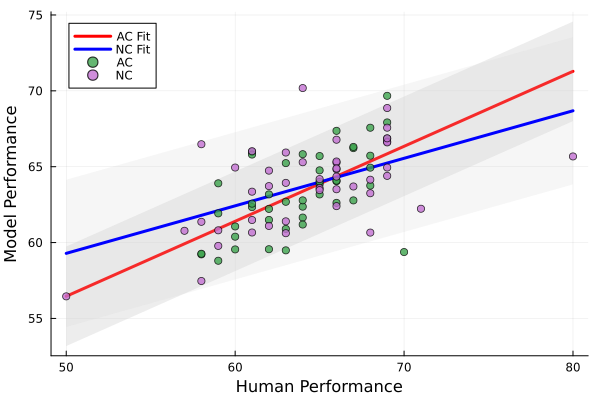

AC: r = 0.6040942897885488, R² = 0.3649299109551315, p = 1.113705768837739e-5
NC: r = 0.5500171297694717, R² = 0.3025188430398479, p = 9.082998057722572e-5


In [62]:
plot()

# --- Correlations ---
r_ac = cor(ac_endings, ac_model_means)
p_ac = pvalue(CorrelationTest(ac_endings, ac_model_means))

r_nc = cor(nc_endings, nc_model_means)
p_nc = pvalue(CorrelationTest(nc_endings, nc_model_means))

# --- DataFrames ---
df_ac = DataFrame(Y = Float64.(ac_model_means), x = Float64.(ac_endings))
df_nc = DataFrame(Y = Float64.(nc_model_means), x = Float64.(nc_endings))

# --- Regressions ---
line_ac = lm(@formula(Y ~ x), df_ac)
line_nc = lm(@formula(Y ~ x), df_nc)

rsq_ac = r2(line_ac)
rsq_nc = r2(line_nc)

# --- Regression lines ---
x_vals = range(
    minimum(vcat(df_ac.x, df_nc.x)),
    maximum(vcat(df_ac.x, df_nc.x)),
    length = 200
)

y_ac = predict(line_ac, DataFrame(x = x_vals))
y_nc = predict(line_nc, DataFrame(x = x_vals))

# --- AC regression + std band ---
viz = plot(
    x_vals,
    y_ac,
    label = "AC Fit",
    color = :red,
    linewidth = 3,
    ribbon = std_ac,
    fillalpha = 0.4,
    fillcolor = :lightgray
)

plot!(
    x_vals,
    y_nc,
    label = "NC Fit",
    color = :blue,
    linewidth = 3,
    ribbon = std_nc,
    fillalpha = 0.2,
    fillcolor = :lightgray
)

# --- Scatter base ---
scatter!(
    df_ac.x, df_ac.Y,
    label = "AC",
    xlabel = "Human Performance",
    ylabel = "Model Performance",
    alpha = 0.8
)

scatter!(
    df_nc.x, df_nc.Y,
    label = "NC",
    alpha = 0.8
)

display(viz)

println("AC: r = $r_ac, R² = $rsq_ac, p = $p_ac")
println("NC: r = $r_nc, R² = $rsq_nc, p = $p_nc")

In [63]:
# Combined AC and NC correlation
all_endings = vcat(ac_endings, nc_endings)
all_model_means = vcat(ac_model_means, nc_model_means)

r_all = cor(all_endings, all_model_means)
p_all = pvalue(CorrelationTest(all_endings, all_model_means))

df_all = DataFrame(
    Y = vcat(Float64.(ac_model_means), Float64.(nc_model_means)),
    x = vcat(Float64.(ac_endings),     Float64.(nc_endings))
)
line_all = lm(@formula(Y ~ x), df_all)

rsq_all = r2(line_all)

println("Combined: r = $r_all, R² = $rsq_all, p = $p_all")

Combined: r = 0.5644800255254533, R² = 0.3186376992172162, p = 6.849727156887073e-9


In [36]:
# Reusing the magnetic potential
function calculate_magnetism(note::Note, key::MusicalScale)
    nearest = findnearest(note, key.notes)
    second_nearest = findnearest(note, key.notes, nearest)

    dto   = abs(note.value - nearest.value)
    dfrom = abs(note.value - second_nearest.value)

    magnetism_force = (1 / (dto^2 + 1)) - (1 / (dfrom^2 + 1))

    return magnetism_force
end
;

In [37]:
Random.seed!(704)

num_melodies = length(ac_melodies)
ac_model_means = Vector{Float64}(undef, num_melodies)
nc_model_means = Vector{Float64}(undef, num_melodies)

for i in ProgressBar(1:num_melodies)
    ac_model_means[i] = particle_mean_last_note(ac_melodies[i], positions[i], keys[i])
    nc_model_means[i] = particle_mean_last_note(nc_melodies[i], positions[i], keys[i])
end
;

0.0%┣                                               ┫ 0/45 [00:00<00:00, -0s/it]
2.2%┣█                                          ┫ 1/45 [00:01<Inf:Inf, InfGs/it]
4.4%┣██▏                                             ┫ 2/45 [00:01<00:52, 1s/it]
6.7%┣███▏                                            ┫ 3/45 [00:02<00:41, 1it/s]
8.9%┣████▎                                           ┫ 4/45 [00:03<00:36, 1it/s]
11.1%┣█████▏                                         ┫ 5/45 [00:03<00:34, 1it/s]
13.3%┣██████▎                                        ┫ 6/45 [00:04<00:32, 1it/s]
15.6%┣███████▎                                       ┫ 7/45 [00:05<00:29, 1it/s]
17.8%┣████████▍                                      ┫ 8/45 [00:05<00:27, 1it/s]
20.0%┣█████████▍                                     ┫ 9/45 [00:06<00:26, 1it/s]
22.2%┣██████████▏                                   ┫ 10/45 [00:06<00:24, 1it/s]
24.4%┣███████████▎                                  ┫ 11/45 [00:07<00:23, 1it/s]
26.7%┣████████████▎         

In [38]:
# Final summary statistics
ac_res = mean(abs.(ac_model_means .- ac_endings))
nc_res = mean(abs.(nc_model_means .- nc_endings))
std_ac = std(ac_endings)
std_nc = std(nc_endings)

println("AC: residual = $ac_res, std = $std_ac")
println("NC: residual = $nc_res, std = $std_nc")

AC: residual = 2.057757611967923, std = 3.2809520668011087
NC: residual = 3.1186354087396393, std = 4.853718765914014


In [39]:
# --- Correlations ---
r_ac = cor(ac_endings, ac_model_means)
p_ac = pvalue(CorrelationTest(ac_endings, ac_model_means))

r_nc = cor(nc_endings, nc_model_means)
p_nc = pvalue(CorrelationTest(nc_endings, nc_model_means))

# --- DataFrames ---
df_ac = DataFrame(Y = Float64.(ac_model_means), x = Float64.(ac_endings))
df_nc = DataFrame(Y = Float64.(nc_model_means), x = Float64.(nc_endings))

# --- Regressions ---
line_ac = lm(@formula(Y ~ x), df_ac)
line_nc = lm(@formula(Y ~ x), df_nc)

rsq_ac = r2(line_ac)
rsq_nc = r2(line_nc)

# --- Regression lines ---
x_vals = range(
    minimum(vcat(df_ac.x, df_nc.x)),
    maximum(vcat(df_ac.x, df_nc.x)),
    length = 200
)

y_ac = predict(line_ac, DataFrame(x = x_vals))
y_nc = predict(line_nc, DataFrame(x = x_vals))

println("AC: r = $r_ac, R² = $rsq_ac, p = $p_ac")
println("NC: r = $r_nc, R² = $rsq_nc, p = $p_nc")

AC: r = 0.5734575076508188, R² = 0.32885351308108857, p = 3.826795047107556e-5
NC: r = 0.4546715941297256, R² = 0.2067262585084666, p = 0.001702609039238978


In [ ]:
# 